In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import os
import glob
from collections import Counter

In [3]:
import sklearn
print(sklearn.__version__)
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

1.6.1


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Define Preprocessing Functions

In [ ]:
# 1 s windows with 50% overlap. Label with majority class. Rule = remove windows that don't have 90% same majority
def create_sliding_windows(df, window_length=1, stepsize=0.5):
    # initialize
    windows = [] # to save output
    start = df['Time'].min()
    end_time = df['Time'].max()

    while start + window_length <= end_time:
        end = start + window_length
        # create df per window
        window_df = df[(df['Time'] >= start) & (df['Time'] <= end)]

        # define majority event label
        labels = window_df['GeneralEvent'].tolist()
        label_counts = Counter(labels) # keeps count of elements in an iterable
        top_label, top_count = label_counts.most_common(1)[0]
        percentage = top_count/len(labels)

        # if 95% of same event label, keep window, add to output
        if percentage >= 0.95:
            windows.append({
                'start': start,
                'end': end,
                'label': top_label,
                'row indices': window_df.index.tolist()
            })

        # slide window
        start += stepsize

    return windows


In [ ]:
def feature_extraction(df, participant_id, windows, features):
    output_rows = []

    for i, window in enumerate(windows):
        window_data = df.loc[window['row indices'],features] # defines what data is in each window

        # define rows via dictionary
        row = {
        'Participant': f'{participant_id}',
        'Window': i + 1,
        'GeneralEvent': window['label'] }

        # add to dictionary, column-specific operations
        for col in features:  # computing for every column, which separates X,Y,Z
            data = window_data[col]
            row[f'{col}_mean'] = data.mean()
            row[f'{col}_std'] = data.std()
            row[f'{col}_max'] = data.max()
            row[f'{col}_min'] = data.min()
            row[f'{col}_rms'] = np.sqrt(np.mean(np.square(data)))

            # peak counts and zero crossing require variable is oscilliatory: FreeAcc and Gyr only
            names = ['FreeAcc', 'Gyr']
            if any(name in col for name in names): # check if any substring in col matches either of the strings in name
                row[f'{col}_zerocross'] = ((data[:-1] * data[1:]) < 0).sum() # el-wise product of consecutive pairs. # num < 0 = # zerocross
                peaks, properties = find_peaks(data)
                row[f'{col}_peakcount'] = len(peaks) # peak count

        output_rows.append(row) # add to output
        features_df = pd.DataFrame(output_rows)

    return features_df

In [ ]:
def preprocess(df, participant_id):

    # remove columns with NA
    df.dropna(axis=1, inplace=True)

    # fix Time data type
    df['Time'] = df['Time'].str.replace(" sec", "").astype(float)

    # create sliding windows
    windows = create_sliding_windows(df)

    # feature engineering per window
    # identify cols
    names = ['FreeAcc', 'Gyr', 'VelInc', 'Roll', 'Pitch', 'Yaw']
    chosen_variables = []

    for col in df.columns.tolist():
        for n in names:
            if n in col:
                chosen_variables.append(col)
    # extract feats
    wf_df = feature_extraction(df, participant_id, windows, chosen_variables)

    return wf_df

In [ ]:
def get_pt_id(file_path): # based on file naming convention
    # get filename
    filename = os.path.basename(file_path)
    # split string, get all before '_tug'
    participant_id = filename.split('_tug')[0]
    return participant_id

In [ ]:
# read in files from csv
csv_folder = r"C:\Users\sabin\OneDrive\Desktop\ML Wearables Project\synapse_data"
csv_folder_PD = r"C:\Users\sabin\OneDrive\Desktop\ML Wearables Project\synapse_data_PD"

# 2. Get list of all CSV files in that folder
csv_files = glob.glob(os.path.join(csv_folder, '*.csv')) # 65 files
csv_files_PD = glob.glob(os.path.join(csv_folder_PD, '*.csv')) # 61
all_files = csv_files + csv_files_PD

In [ ]:
# create list of all pre-processed dfs
processed_dfs = []
for file in all_files:
    df = pd.read_csv(file)
    participant_id = get_pt_id(file)
    wf_df = preprocess(df, participant_id)
    processed_dfs.append(wf_df)

# # create DataFrame out of list of pre-processed dfs
df = pd.concat(processed_dfs, ignore_index=True)

# Read in preprocessed data (avoid pre-processing large files every time)

In [7]:
df = pd.read_csv('/home/sbinder3/wearables/preprocessed_df.csv')


In [8]:
# now check for NaN
count = 0
for col in df.columns.tolist():
    if df[col].isna().sum() > 0:
        #print(f'{col}: {df[col].isna().sum()}')
        count += 1
print(count)
# 792 columns missing data
# ranges from 100-527 rows with NA.. drop rows with NA.. still will have 10K rows

792


In [9]:
dff = df.dropna(axis=0) # drop rows with NA

In [10]:
num_pts = len(np.unique(dff['Participant'])) # drops 23 participants
print(f'Number of Participants included in data: {num_pts}')

Number of Participants included in data: 103


In [11]:
# drop rows where Event = 'unlabeled'
df_clean = dff[dff['GeneralEvent'] != 'unlabeled']

In [12]:
df_clean.shape

(8235, 939)

In [13]:
# Add label: normal control or PD

df_clean['Diagnosis'] = df_clean['Participant'].astype(str).apply(
    lambda x: 0 if x.startswith(("HC", "WHC")) else 1) # 0 for NC 1 for PD

/tmp/ipykernel_2514059/4225072674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Diagnosis'] = df_clean['Participant'].astype(str).apply(


In [14]:
df_clean = df_clean.reset_index() # handle warning
df_clean

,index,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,...,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms,Diagnosis
0,0,HC127,1,Sitting,0.039422,0.026305,0.090083,-0.042820,0.047320,0.0,...,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570,0
1,1,HC127,2,Sitting,0.038468,0.024624,0.110037,-0.042820,0.045608,0.0,...,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811,0
2,2,HC127,3,Sitting,0.038304,0.018826,0.110037,-0.008691,0.042639,0.0,...,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758,0
3,3,HC127,4,Sitting,0.039163,0.019854,0.089022,-0.005469,0.043863,0.0,...,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843,0
4,4,HC127,5,Sitting,0.039559,0.021399,0.093039,-0.013712,0.044925,0.0,...,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,10276,NLS022,61,Sitting,0.044224,0.031367,0.121560,-0.037111,0.054129,0.0,...,0.181484,0.539548,-0.169947,0.258366,-143.096121,3.536851,-136.907151,-146.082444,143.139391,1
8231,10277,NLS022,62,Sitting,0.017734,0.027936,0.089327,-0.037618,0.032972,0.0,...,0.184555,0.539548,-0.040658,0.385258,-138.063167,3.276524,-134.448461,-145.395194,138.101656,1
8232,10278,NLS022,63,Sitting,-0.004072,0.025544,0.064759,-0.057539,0.025741,0.0,...,0.280925,1.159762,0.288697,0.635361,-133.045931,3.464658,-125.049828,-136.907151,133.090588,1
8233,10279,NLS022,64,Sitting,-0.018309,0.050238,0.146274,-0.168325,0.053237,0.0,...,0.776763,2.532875,0.337477,1.548004,-126.274312,4.744236,-121.087059,-134.448461,126.362522,1


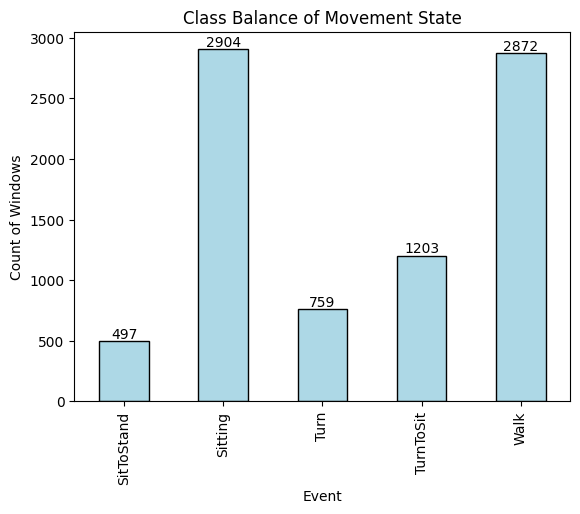

In [ ]:
grouped_df = df_clean.groupby('GeneralEvent').count()
ax = grouped_df['Participant'].plot(kind='bar', color='lightblue', edgecolor='black')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, height, ha="center", va='bottom')

plt.xlabel('Event')
plt.ylabel('Count of Windows')
plt.title('Class Balance of Movement State')
plt.show()


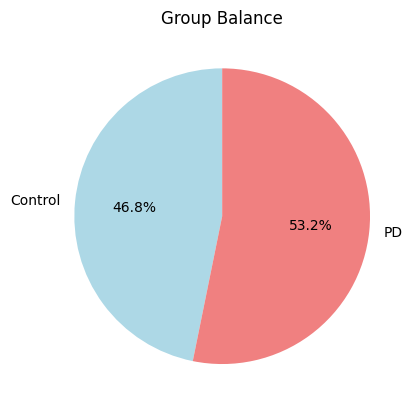

In [ ]:
dfg = df_clean.groupby('Diagnosis').count()
labels = ['Control', 'PD']
colors = ['lightblue', 'lightcoral']

dfg['index'].plot(kind='pie', labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Group Balance')
plt.show()


In [15]:
df_clean = df_clean.copy()

In [16]:
df_clean.head()

,index,Participant,Window,GeneralEvent,LowerBack_FreeAcc_E_mean,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,...,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms,Diagnosis
0,0,HC127,1,Sitting,0.039422,0.026305,0.090083,-0.042820,0.047320,0.0,...,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570,0
1,1,HC127,2,Sitting,0.038468,0.024624,0.110037,-0.042820,0.045608,0.0,...,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811,0
2,2,HC127,3,Sitting,0.038304,0.018826,0.110037,-0.008691,0.042639,0.0,...,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758,0
3,3,HC127,4,Sitting,0.039163,0.019854,0.089022,-0.005469,0.043863,0.0,...,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843,0
4,4,HC127,5,Sitting,0.039559,0.021399,0.093039,-0.013712,0.044925,0.0,...,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069,0


In [17]:
df_clean.iloc[:,5:-1] # exclude metadata cols

,LowerBack_FreeAcc_E_std,LowerBack_FreeAcc_E_max,LowerBack_FreeAcc_E_min,LowerBack_FreeAcc_E_rms,LowerBack_FreeAcc_E_zerocross,LowerBack_FreeAcc_E_peakcount,LowerBack_FreeAcc_N_mean,LowerBack_FreeAcc_N_std,LowerBack_FreeAcc_N_max,LowerBack_FreeAcc_N_min,...,Forehead_Pitch_mean,Forehead_Pitch_std,Forehead_Pitch_max,Forehead_Pitch_min,Forehead_Pitch_rms,Forehead_Yaw_mean,Forehead_Yaw_std,Forehead_Yaw_max,Forehead_Yaw_min,Forehead_Yaw_rms
0,0.026305,0.090083,-0.042820,0.047320,0.0,32.0,-0.001104,0.024406,0.051831,-0.089618,...,0.937011,0.173643,1.358843,0.711304,0.952808,-153.779252,0.314757,-153.466063,-154.364778,153.779570
1,0.024624,0.110037,-0.042820,0.045608,0.0,32.0,-0.004288,0.025047,0.051831,-0.089618,...,0.724209,0.115384,0.991361,0.541487,0.733253,-153.685757,0.129581,-153.469367,-153.908175,153.685811
2,0.018826,0.110037,-0.008691,0.042639,0.0,33.0,-0.005689,0.019059,0.030665,-0.061124,...,0.614142,0.056648,0.746514,0.528558,0.616723,-153.816740,0.073660,-153.639564,-153.930343,153.816758
3,0.019854,0.089022,-0.005469,0.043863,0.0,36.0,-0.003516,0.018023,0.030408,-0.061124,...,0.347224,0.284128,0.626406,-0.106558,0.447766,-153.863831,0.061721,-153.734824,-153.955624,153.863843
4,0.021399,0.093039,-0.013712,0.044925,0.0,34.0,-0.003159,0.019035,0.031654,-0.042662,...,0.048113,0.162789,0.528558,-0.158192,0.168976,-153.666869,0.248967,-153.242950,-153.955624,153.667069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0.031367,0.121560,-0.037111,0.054129,0.0,30.0,0.014393,0.021798,0.060970,-0.048083,...,0.184778,0.181484,0.539548,-0.169947,0.258366,-143.096121,3.536851,-136.907151,-146.082444,143.139391
8231,0.027936,0.089327,-0.037618,0.032972,0.0,29.0,0.008887,0.018049,0.063843,-0.038356,...,0.338675,0.184555,0.539548,-0.040658,0.385258,-138.063167,3.276524,-134.448461,-145.395194,138.101656
8232,0.025544,0.064759,-0.057539,0.025741,0.0,29.0,0.001438,0.017228,0.063843,-0.058876,...,0.570566,0.280925,1.159762,0.288697,0.635361,-133.045931,3.464658,-125.049828,-136.907151,133.090588
8233,0.050238,0.146274,-0.168325,0.053237,0.0,27.0,-0.003377,0.033770,0.074499,-0.100042,...,1.341241,0.776763,2.532875,0.337477,1.548004,-126.274312,4.744236,-121.087059,-134.448461,126.362522


In [18]:
# define
group_labels = df_clean['Participant'].to_numpy() # don't sep a single pt's data btwn train and test phases
X = df_clean.iloc[:,5:-1].to_numpy() # identifer (window index) gets dropped # up to row 5 removes General Event
y = np.unique(df_clean['GeneralEvent'], return_inverse=True)[1] # creates classes: 0,1,2,3,4


In [19]:
np.unique(df_clean['GeneralEvent'])

array(['SitToStand', 'Sitting', 'Turn', 'TurnToSit', 'Walk'], dtype=object)

In [20]:
X.shape
#y.shape
#group_labels.shape

(8235, 935)

# Logistic Regression

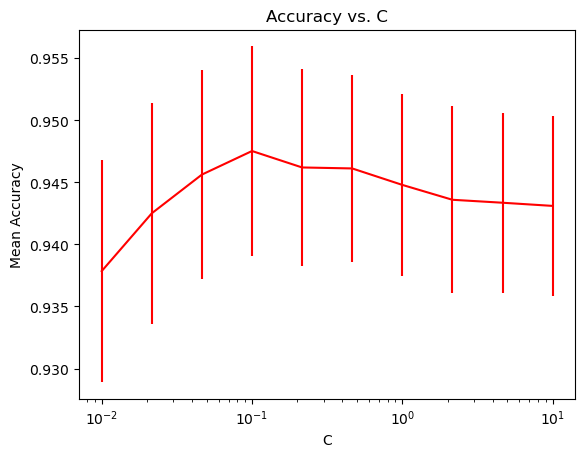

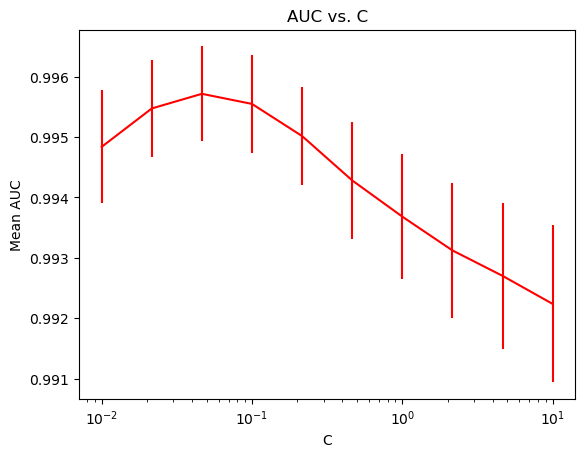

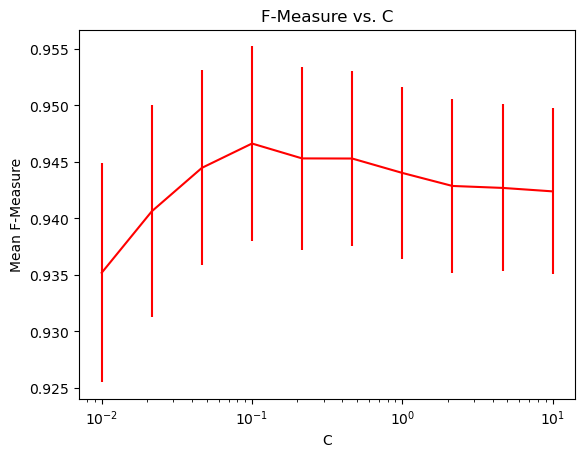

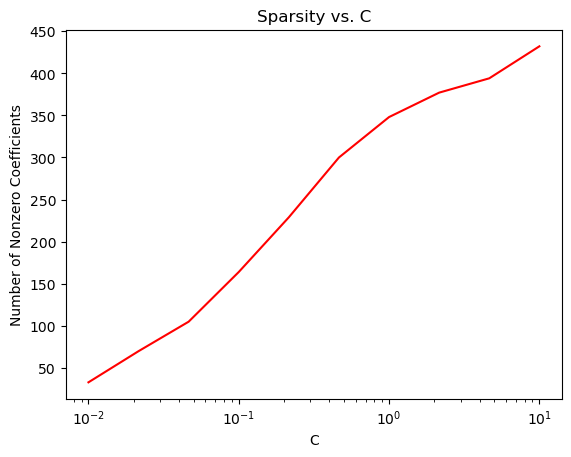

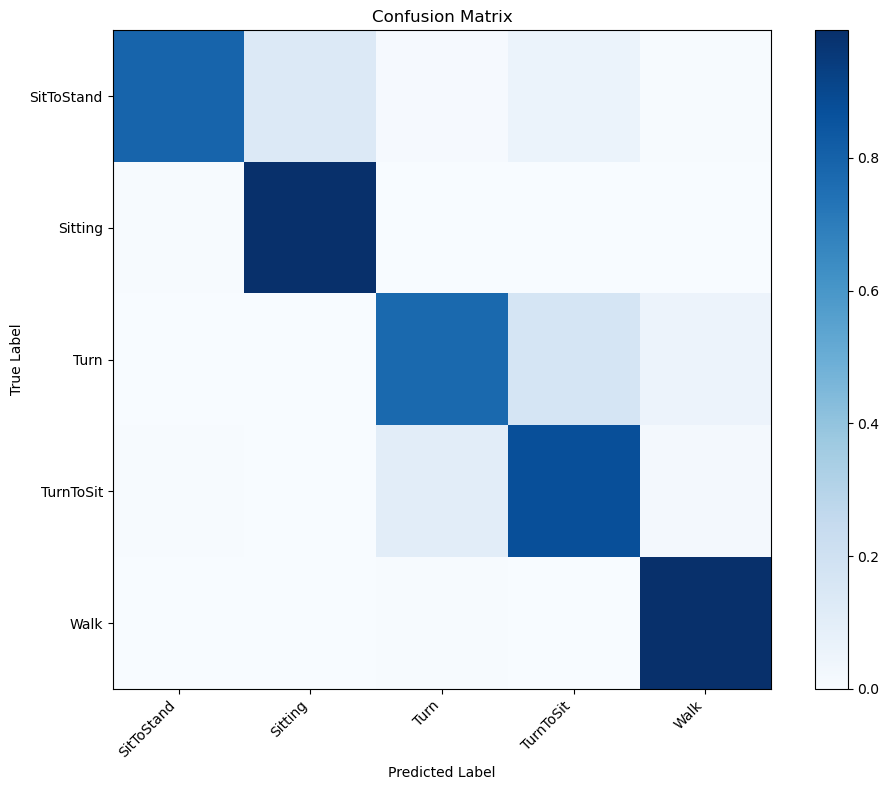

Best C Index: 3
Best C value based on Max Accuracy: 0.1000 with accuracy 0.9475, AUC 0.995550049330354
Best C value based on Max F-Measure: 0.1000 with f-measure 0.9818
Best C value based on Max AUC: 0.0464 with auc 0.9957
Best performance with 164 features


In [43]:
all_labels = np.unique(y)
cat_labels = np.unique(df_clean['GeneralEvent'])

# dict to store results of metrics
results_dict = {}

# Initialize objects
nfold = 10
c_values = np.logspace(-2, 1, 10) # to test out: # smaller C increases regularization

# create group kfold obj
gkf = GroupKFold(n_splits=nfold, shuffle=True, random_state=42) # shuffle = True bc df compiled in order of diagnosis & site

# initialize to store metrics/weights across folds
acc = np.zeros((len(c_values), nfold)) # 20 x 10 matrix
auc = np.zeros((len(c_values), nfold))
all_yts = [] # for confusion matrix
all_yhat = [] # for confusion matrix
f_measure = np.zeros((len(c_values), nfold))
W = np.zeros((len(c_values), X.shape[1]))  # Store mean coefficient values # 10 x 936: for every c value, store 936 coefs

for ifold, (train_index, test_index) in enumerate(gkf.split(X, y, group_labels)): # ensure groups are not split into train/test per fold
    # Get training and test data
    Xtr, ytr = X[train_index], y[train_index]
    Xts, yts = X[test_index], y[test_index]

    # Scale the data
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts)

    for ic, c in enumerate(c_values):
        # Create and fit model
        logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
        logreg.fit(Xtr1, ytr) # scaled train data

        # Predict and store
        yhat = logreg.predict(Xts1) # scaled test data
        y_prob = logreg.predict_proba(Xts1) # for AUC
        acc[ic, ifold] = np.mean(yhat == yts) # per ith c and ith fold
        auc[ic, ifold] = roc_auc_score(yts, y_prob, multi_class='ovr', average='weighted', labels=all_labels)
        f_measure[ic, ifold] = f1_score(yts, yhat, average='weighted')

        # for confusion matirx
        all_yts.extend(yts)
        all_yhat.extend(yhat)

        # Store mean absolute coefficients across folds
        W[ic] += np.abs(logreg.coef_[0]) / nfold

# Compute mean accuracy for each C
acc_mean = acc.mean(axis=1)
acc_se = acc.std(axis=1) / np.sqrt(nfold)

# compute mean AUC for every C value testred
auc_mean = auc.mean(axis=1)
auc_se = auc.std(axis=1) / np.sqrt(nfold)

# Plot accuracy vs. C
plt.errorbar(c_values, acc_mean, color='red', yerr=acc_se)
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy vs. C")
plt.show()

# Plot auc vs. C
plt.errorbar(c_values, auc_mean, color='red', yerr=auc_se)
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Mean AUC")
plt.title("AUC vs. C")
plt.show()

# Plot f-measure vs. C
f1_mean = f_measure.mean(axis=1)
plt.errorbar(c_values, f1_mean, color='red', yerr=f_measure.std(axis=1) / np.sqrt(nfold))
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Mean F-Measure")
plt.title("F-Measure vs. C")
plt.show()

# Plot sparsity effect (how many nonzero coefficients)
plt.plot(c_values, np.count_nonzero(W, axis=1), color='red')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Number of Nonzero Coefficients")
plt.title("Sparsity vs. C")
plt.show()

# compute and plot confusion matrix
cm = confusion_matrix(all_yts, all_yhat, labels=np.arange(len(cat_labels)), normalize='true')
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cat_labels))
plt.xticks(tick_marks, cat_labels, rotation=45, ha='right')
plt.yticks(tick_marks, cat_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print best C value
best_c = c_values[np.argmax(acc_mean)]
best_c_index = np.argmax(acc_mean)
print(f'Best C Index: {best_c_index}')
auc_chosenC = auc_mean[best_c_index]
print(f"Best C value based on Max Accuracy: {best_c:.4f} with accuracy {np.max(acc_mean):.4f}, AUC {auc_chosenC}")
f1_chosenC = f1_mean[best_c_index]
print(f"Best C value based on Max F-Measure: {best_c:.4f} with f-measure {np.max(f_measure):.4f}")

# Choose best C based on AUC
best_c_auc = c_values[np.argmax(auc_mean)]
print(f"Best C value based on Max AUC: {best_c_auc:.4f} with auc {np.max(auc_mean):.4f}")

# add to results dict
# model chosen by best accuracy
results_dict['L1 Logistic Regression'] = {
    'Parameters': best_c,
    'Accuracy': np.max(acc_mean),
    'AUC': auc_chosenC,
    'F-Measure': f1_chosenC
}

# non -zero
indices_non_zero = np.where(W[best_c_index,:] > 0)
print(f'Best performance with {len((indices_non_zero)[0])} features')

# save nonzero columns that are selected via Lasso regression
columns = []
x = df_clean.iloc[:,5:]
for col in x.columns[indices_non_zero[0]]:
    columns.append(col)




In [ ]:
from collections import defaultdict

sensor_locations = defaultdict(int)

for col in columns:
    if 'LowerBack' in col:
        sensor_locations['LowerBack'] += 1
    elif 'Wrist' in col:
        sensor_locations['Wrist'] += 1
    elif 'MidLatThigh' in col:
        sensor_locations['MidLatThigh'] += 1
    elif 'LatShank' in col:
        sensor_locations['LatShank'] += 1
    elif 'DorsalFoot' in col:
        sensor_locations['DorsalFoot'] += 1
    elif 'Ankle' in col:
        sensor_locations['Ankle'] += 1
    elif 'Xiphoid' in col:
        sensor_locations['Xiphoid'] += 1
    elif 'Forehead' in col:
        sensor_locations['Forehead'] += 1
    else:
        print(f'group not listed: {col}')

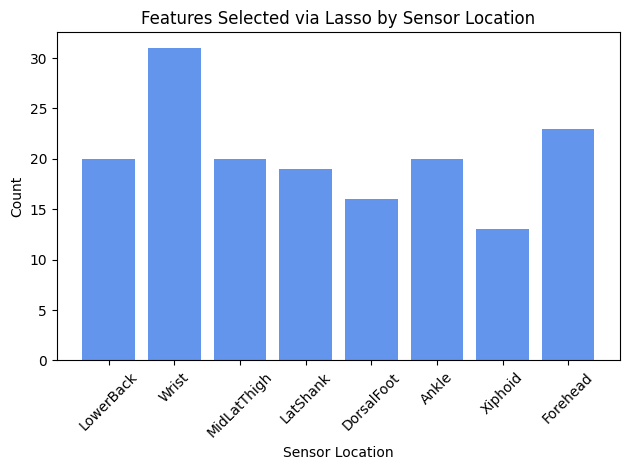

In [ ]:
sensor_locations.pop(0,None) # unwanted key

plt.bar(sensor_locations.keys(), sensor_locations.values(), color='cornflowerblue')
plt.xlabel('Sensor Location')
plt.ylabel('Count')
plt.title('Features Selected via Lasso by Sensor Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize Multicollinearty

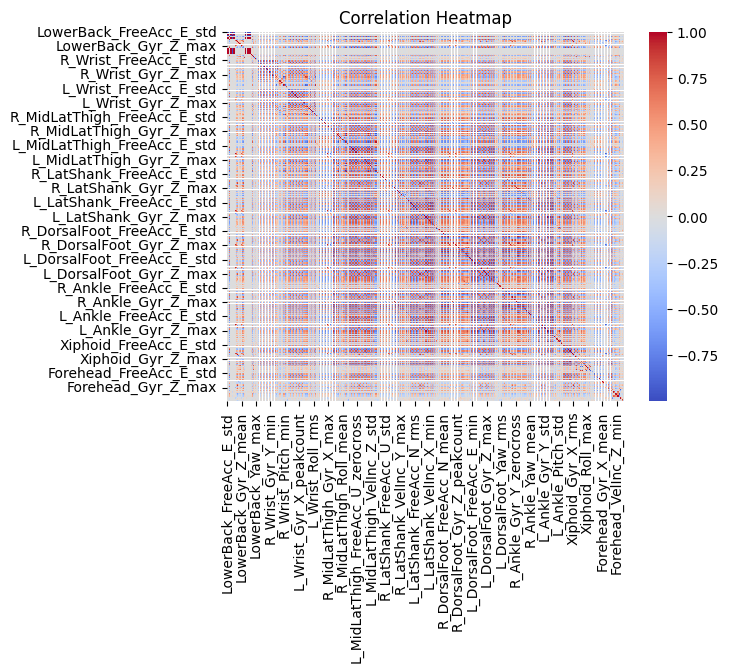

In [39]:
# data = X
data = df_clean.iloc[:,5:-1]

corr_matrix = data.corr()

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# PCA PoV

Optimal ncomponents capturing 95.0% of Var: 209
Optimal ncomponents capturing 97.0% of Var: 278
Optimal ncomponents capturing 98.0% of Var: 335
Optimal ncomponents capturing 99.0% of Var: 424


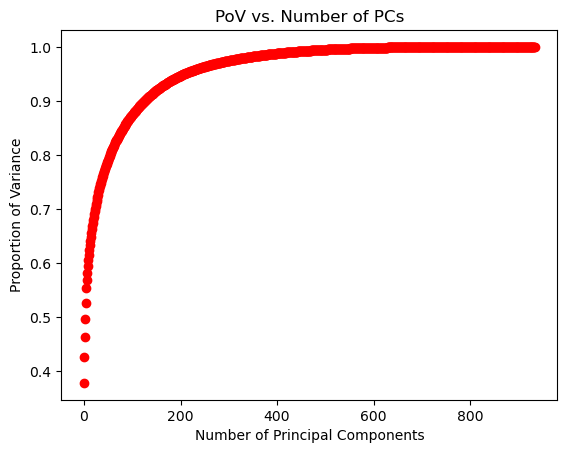

In [21]:


def pca_pov(X):
    # scale X
    scal = StandardScaler()
    X_scaled = scal.fit_transform(X)

    # define nfeatures (ALL)
    nfeat = X.shape[1]

    # pca
    pca = PCA(n_components=nfeat, svd_solver='auto', whiten=True)
    pca.fit(X_scaled)

    # get eigenvalues
    s = pca.singular_values_ # eigenvalues corresponding to the selected components (eigenvectors)

    # calc pov
    denom = np.sum(s**2)
    pov_results = []

    for i in range(1, len(s)+1):
        num = np.sum(s[0:i]**2)
        PoV = num / denom
        pov_results.append(PoV)

    # show optimal number of components
    for p in [0.95, 0.97, 0.98, 0.99]:
        optimal_nc = np.argmax(np.array(pov_results) >= p) + 1  # +1 bc index starts at 0
        print(f"Optimal ncomponents capturing {p*100}% of Var: {optimal_nc}")


    # plot
    x = range(935)
    plt.scatter(x, pov_results, color='red')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Proportion of Variance")
    plt.title("PoV vs. Number of PCs")
    plt.show()

pca_pov(X)


# SVM via GridSearchCV

In [22]:
# Need to shuffle data bc in order of diagnosis and study site
# Gridsearch CV doesnt not directly suppoirt shuffle
X, y, group_labels = shuffle(X, y, group_labels, random_state=42)

# define objects and pipe
scaler = StandardScaler()
gkf = GroupKFold(n_splits=5)
pca = PCA(n_components=278)
svc = SVC(kernel='rbf')
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

# define params to test
c_test = np.logspace(-2, 1, 5)
gam_test = np.logspace(-4, 0, 5)

# create dict of params
params = {'svc__C' : c_test, 'svc__gamma' : gam_test}
scoring={'accuracy': 'accuracy',
        'f1_weighted': make_scorer(f1_score, average='weighted')}

# define and fit object estimator gridsearchcv
estimator = GridSearchCV(pipe, params, scoring=scoring, refit='accuracy', cv=gkf, return_train_score=True)
estimator.fit(X,y, groups=group_labels)

# for metrics # cross_val_predict uses out of fold predictions
yhat = cross_val_predict(estimator.best_estimator_, X, y, groups=group_labels, cv=gkf)


In [26]:
print(f"Best test accuracy score: {estimator.best_score_:.4f}")
print(f"Best parameters: {estimator.best_params_}")

f1 = f1_score(y, yhat, average='weighted')
print(f"CV Performance of Best Estimator:")
print(f"F1 Score (weighted): {f1:.4f}")


Best test accuracy score: 0.9511
Best parameters: {'svc__C': np.float64(10.0), 'svc__gamma': np.float64(0.001)}
CV Performance of Best Estimator:
F1 Score (weighted): 0.9505


In [33]:
cv_results = pd.DataFrame(estimator.cv_results_)

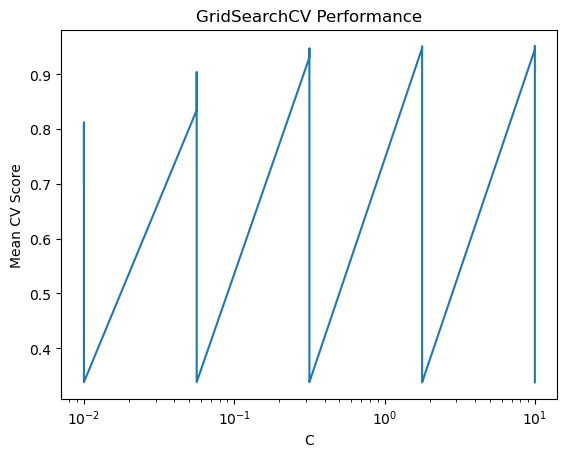

In [37]:
# make df
cv_results = pd.DataFrame(estimator.cv_results_)
# subset to one PCA ncomnp

C_values = cv_results['param_svc__C'].astype(float)
mean_scores = cv_results["mean_test_accuracy"]

# Sort by C
sorted_idx = np.argsort(C_values)
C_sorted = C_values[sorted_idx]
scores_sorted = mean_scores[sorted_idx]

plt.plot(C_sorted, scores_sorted)
plt.xlabel("C")
plt.ylabel("Mean CV Score")
plt.xscale("log")
plt.title("GridSearchCV Performance")
plt.show()

Text(0.5, 1.0, 'Grid Search Accuracy')

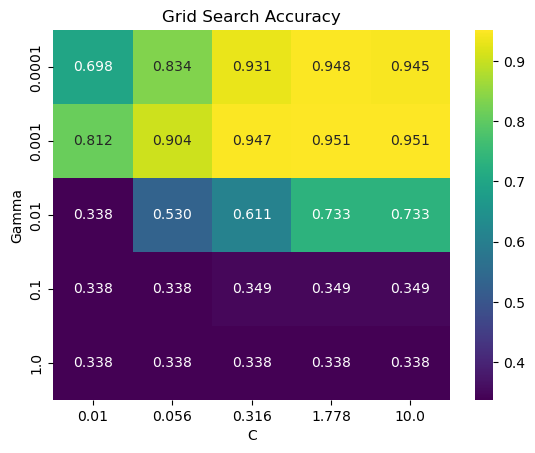

In [41]:
results = estimator.cv_results_

# Get C and gamma
C_vals = np.array(results['param_svc__C'])
gamma_vals = np.array(results['param_svc__gamma'])
test_scores = np.array(results['mean_test_accuracy'])

# Reshape for plotting
C_unique = np.sort(np.unique(C_vals))
C_rounded = np.round(C_unique, 3)
gamma_unique = np.sort(np.unique(gamma_vals))

# reshape test scores into a matrix for imshow
score_matrix = test_scores.reshape(len(gamma_unique), len(C_unique)).T

# Build DataFrame
heat_df = pd.DataFrame(score_matrix, index=gamma_unique, columns=C_rounded)
sns.heatmap(heat_df, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.title("Grid Search Accuracy")
